## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [1]:
img_dir = '/home/locobotm/AVD/habitat_data_with_seg/rgb/'
# train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'
train_json = 'habitat_sem_annot3.json' # label prop train data
test_json = 'habitat_sem_annot3.json' # '/home/locobotm/AVD/habitat_data_with_seg/test.json'
dataset_name = 'habitat_1'

In [2]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))


Bad key text.latex.unicode in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You proba

## Detectron2 Setup

In [3]:
DatasetCatalog.clear()
MetadataCatalog.clear()
train_data = dataset_name +  "_train"
val_data = dataset_name + "_val"
from detectron2.data.datasets import register_coco_instances
register_coco_instances(train_data, {}, train_json, img_dir)
register_coco_instances(val_data, {}, test_json, img_dir)

from detectron2.data import DatasetMapper, build_detection_train_loader

MetadataCatalog.get(train_data)

## Visualizing the dataset

[03/11 14:10:31 d2.data.datasets.coco]: Loaded 240 images in COCO format from habitat_sem_annot3.json


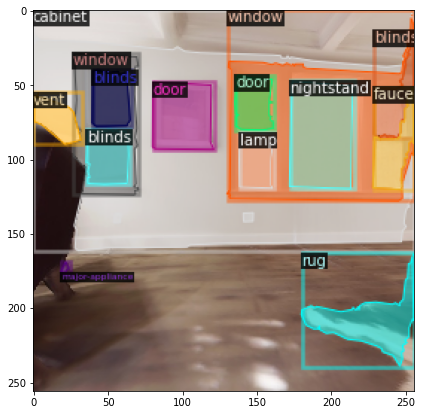

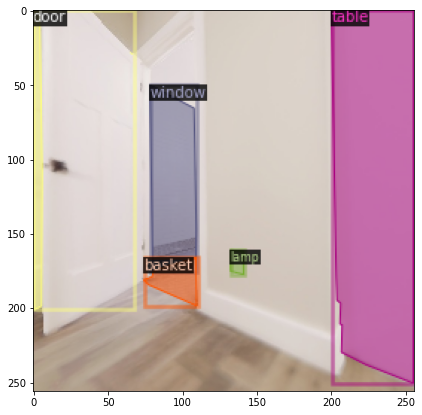

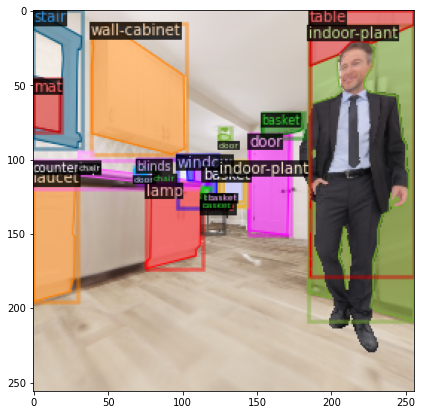

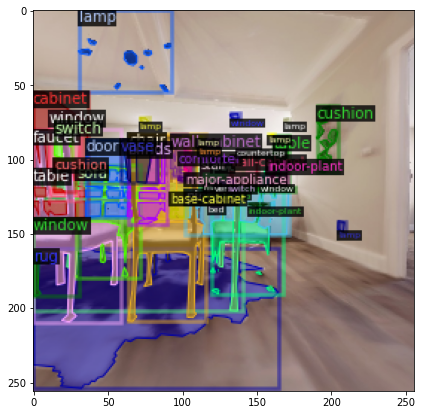

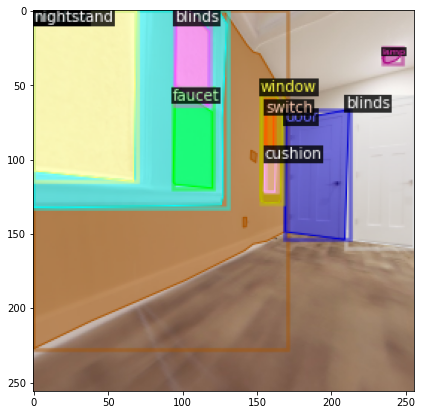

In [5]:
import random

dataset_dicts = DatasetCatalog.get(train_data)

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(train_data), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.imshow(img)
    plt.show()

In [6]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
cfg.DATASETS.TRAIN = (train_data,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
cfg.SOLVER.MAX_ITER = 500 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(train_data).get("thing_classes"))  # only has one class (ballon)

## Training

In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

[03/11 14:10:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (102, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (102,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (404, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (404,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (101, 256

[03/11 14:10:35 d2.engine.train_loop]: Starting training from iteration 0


/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/layers/wrappers.py:240: UserWarning: This overload of nonze

[03/11 14:10:40 d2.utils.events]:  eta: 0:01:47  iter: 19  total_loss: 7.308  loss_cls: 4.649  loss_box_reg: 0.816  loss_mask: 0.6923  loss_rpn_cls: 1.02  loss_rpn_loc: 0.302  time: 0.2266  data_time: 0.0095  lr: 9.9905e-05  max_mem: 1863M
[03/11 14:10:44 d2.utils.events]:  eta: 0:01:41  iter: 39  total_loss: 4.141  loss_cls: 1.998  loss_box_reg: 0.8253  loss_mask: 0.6871  loss_rpn_cls: 0.2009  loss_rpn_loc: 0.4162  time: 0.2243  data_time: 0.0039  lr: 0.0001998  max_mem: 1863M
[03/11 14:10:49 d2.utils.events]:  eta: 0:01:37  iter: 59  total_loss: 3.695  loss_cls: 1.512  loss_box_reg: 0.8524  loss_mask: 0.6708  loss_rpn_cls: 0.1742  loss_rpn_loc: 0.3808  time: 0.2257  data_time: 0.0040  lr: 0.0002997  max_mem: 1863M
[03/11 14:10:54 d2.utils.events]:  eta: 0:01:33  iter: 79  total_loss: 3.51  loss_cls: 1.444  loss_box_reg: 0.8389  loss_mask: 0.6598  loss_rpn_cls: 0.144  loss_rpn_loc: 0.4036  time: 0.2299  data_time: 0.0044  lr: 0.00039961  max_mem: 1863M
[03/11 14:10:58 d2.utils.events]

Reusing TensorBoard on port 6006 (pid 25189), started 6 days, 15:07:56 ago. (Use '!kill 25189' to kill it.)

## Evaluation

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(val_data, ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_data)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/11 14:12:35 d2.data.datasets.coco]: Loaded 240 images in COCO format from habitat_sem_annot3.json
[03/11 14:12:35 d2.data.common]: Serializing 240 elements to byte tensors and concatenating them all ...
[03/11 14:12:35 d2.data.common]: Serialized dataset takes 3.10 MiB
[03/11 14:12:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/11 14:12:35 d2.evaluation.evaluator]: Start inference on 240 images
[03/11 14:12:37 d2.evaluation.evaluator]: Inference done 11/240. 0.0701 s / img. ETA=0:00:28
[03/11 14:12:42 d2.evaluation.evaluator]: Inference done 58/240. 0.0660 s / img. ETA=0:00:19
[03/11 14:12:47 d2.evaluation.evaluator]: Inference done 106/240. 0.0653 s / img. ETA=0:00:14
[03/11 14:12:52 d2.evaluation.evaluator]: Inference done 156/240. 0.0650 s / img. ETA=0:00:08
[03/11 14:12:57 d2.evaluation.evaluator]: Inference done 206/240. 0.0649 s / img. ETA=0:00:03
[03/11 

[03/11 14:13:05 d2.data.datasets.coco]: Loaded 240 images in COCO format from habitat_sem_annot3.json
/home/locobotm/AVD/habitat_data_with_seg/rgb/00000.jpg


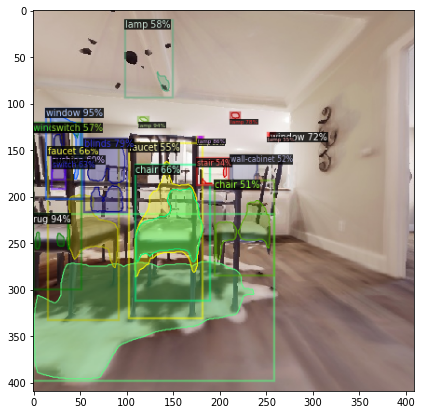

/home/locobotm/AVD/habitat_data_with_seg/rgb/00060.jpg


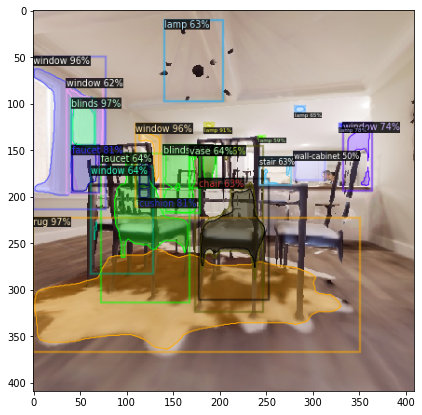

/home/locobotm/AVD/habitat_data_with_seg/rgb/00061.jpg


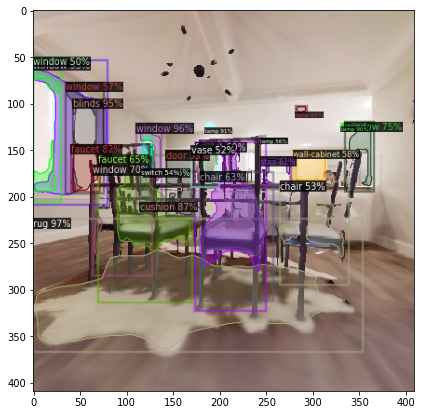

/home/locobotm/AVD/habitat_data_with_seg/rgb/00062.jpg


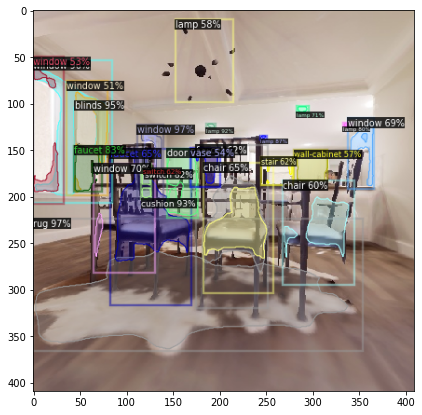

/home/locobotm/AVD/habitat_data_with_seg/rgb/00063.jpg


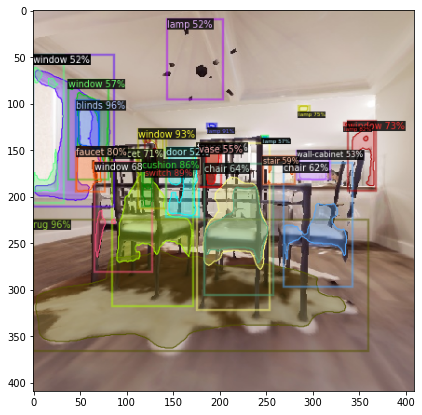

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (val_data, )
predictor = DefaultPredictor(cfg)


def visualize(filename):
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(val_data), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()

for d in DatasetCatalog.get(val_data)[:5]:
    print(d['file_name'])
    visualize(d['file_name'])
